In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from carla_gym.core.obs_manager.birdview.Gaze import GazeDirection
import re
import seaborn as sns

import carla
import yaml
import os

from utils.server_utils import CarlaServerManager

In [2]:
def read_episode_stat_buffers(file_path):
    ep_stat_buf_names = [f for f in os.listdir(file_path) if 'ep_stat_buffer' in f]
    # read the json file
    data_df = pd.DataFrame()
    for f in ep_stat_buf_names:
        json_file_name = os.path.join(file_path, f)
        with open(json_file_name) as json_file:
            json_file = json.load(json_file)
            episode_dicts = json_file['hero']
            for json_file in episode_dicts:
                data_df = data_df.append(json_file, ignore_index=True)
    data_df['encounter_light'] = data_df['encounter_light'].astype(int)
    data_df['encounter_stop'] = data_df['encounter_stop'].astype(int)
    data_df['is_route_completed'] = data_df['is_route_completed'].astype(bool)
    data_df['is_route_completed_nocrash'] = data_df['is_route_completed_nocrash'].astype(bool)
    data_df['light_passed'] = data_df['light_passed'].astype(int)
    data_df['red_light'] = data_df['red_light'].astype(int)
    data_df = data_df.round(2)
    return data_df

def get_episode_with_accidents(df):
    return df[df['is_route_completed_nocrash'] == False]

def df_as_table(df, width=20, length=12):
    df = df.T
    return df

def create_collisions_vehicle_df(file_path, df):
    df = get_episode_with_accidents(df)
    ret = pd.DataFrame()
    for i in range(len(df)):
        row = df.iloc[i]
        suite = row['suite']
        run = row['run']
        file_name = os.path.join(file_path, 'diagnostics', suite, f"{run}.json")
        with open(file_name) as json_file:
            json_file = json.load(json_file)
            json_data = json_file['hero']
            collision_vehicle_info = json_data['collisions_vehicle']
            for collision_vehicle in collision_vehicle_info:
                collision_vehicle['suite'] = suite
                collision_vehicle['run'] = run
                for key in ['normal_impulse', 'event_loc', 'event_rot', 'ev_loc', 'ev_rot', 'ev_vel', 'oa_loc', 'oa_rot', 'oa_vel']:
                    collision_vehicle[f"{key}_x"], collision_vehicle[f"{key}_y"], collision_vehicle[f"{key}_z"] = collision_vehicle.pop(key)
                ret = pd.concat([ret, pd.DataFrame([collision_vehicle])], ignore_index=True)
    ret = ret.round(4)
    return ret

def get_veh_col_scenario_df_with_idx(file_path, df, index, threshold=50):
    row = df.iloc[index]
    suite, run, step, other_agent_id = row['suite'], row['run'], row['step'], row['other_actor_id']
    file_name = os.path.join(file_path, 'diagnostics', suite, f"{run}.csv")
    ego_df = pd.read_csv(file_name)
    ego_df = ego_df[(ego_df['timestamp'] >= step - threshold) & (ego_df['timestamp'] <= step + threshold)]
    ego_df['suite'] = suite
    ego_df['run'] = run
    ego_df['other_actor_id'] = other_agent_id
    # ego_df['perception_error'] = ego_df['perception_error'].apply(lambda x: 0 if x < 0 else x)
    return ego_df

def get_veh_col_scenario_df(file_path, df, threshold=50):
    n_row = len(df)
    ret = pd.DataFrame()
    for i in range(n_row):
        ego_df = get_veh_col_scenario_df_with_idx(file_path, df, i, threshold)
        ret = pd.concat([ret, ego_df], ignore_index=True)
    return ret

def plot_gaze_direction_distribution(df):
    # Map gaze_direction integers to labels
    gaze_labels = {}
    for gd in GazeDirection:
        gaze_labels[f"GazeDirection.{gd.name}"] = gd.value
    df['gaze_direction'] = df['gaze_direction'].map(gaze_labels)
    sns.set_theme(style="darkgrid")
    plt.figure(figsize=(12, 6))
    sns.histplot(df['gaze_direction'], bins=range(0, 8), discrete=True, stat='count', kde=False)
    plt.xlabel('Gaze Direction')
    plt.ylabel('Frequency')
    plt.title('Gaze Direction Distribution')
    plt.xticks(rotation=45)  

def plot_ego_df(ax, df, col_name):
    if 'gaze_direction' in col_name:
        gaze_labels = {}
        for gd in GazeDirection:
            gaze_labels[f"GazeDirection.{gd.name}"] = gd.value
        df['gaze_direction'] = df['gaze_direction'].map(gaze_labels)
        pass
    sns.set_theme(style="darkgrid")
    sns.lineplot(ax=ax, x='timestamp', y=col_name, data=df, marker='.', label=col_name)
    median_step = df['timestamp'].median()
    ax.axvline(x=median_step, color='r', linestyle='--', label='Median Step')
    ax.set_xlabel('Step')
    ax.set_ylabel('Value')
    ax.set_title(f'Step vs {col_name}')
    ax.legend()

def show_gaze_vs_error(df):
    fig, axs = plt.subplots(1, 2, figsize=(15, 3))  # Create a figure with 1 row and 2 columns of subplots
    plot_ego_df(axs[0], df, 'gaze_direction')
    plot_ego_df(axs[1], df, 'perception_error')
    plt.tight_layout()  # Adjust layout
    plt.show()

In [3]:
# basic1 = read_episode_stat_buffers(simulation_folder['basic1'])
# basic2 = read_episode_stat_buffers(simulation_folder['basic2'])

# equal1 = read_episode_stat_buffers(simulation_folder['equal1'])
# equal2 = read_episode_stat_buffers(simulation_folder['equal2'])

# gaussian1 = read_episode_stat_buffers(simulation_folder['gaussian1'])
# gaussian2 = read_episode_stat_buffers(simulation_folder['gaussian2'])

# strong_memory_equal1 = read_episode_stat_buffers(simulation_folder['strong_memory_equal1'])
# strong_memory_gaussian1 = read_episode_stat_buffers(simulation_folder['strong_memory_gaussian1'])



In [14]:
simulation_folder = {
    # 'basic1' : r'C:\Users\abjawad\Documents\GitHub\carla-roach-0.9.13\outputs\2024-04-05\12-11-57',
    # 'basic2' : r'C:\Users\abjawad\Documents\GitHub\carla-roach-0.9.13\outputs\2024-04-05\18-23-29',
    # 'equal1' : r'C:\Users\abjawad\Documents\GitHub\carla-roach-0.9.13\outputs\2024-04-05\01-41-35',
    'equal2' : r'C:\Users\abjawad\Documents\GitHub\carla-roach-0.9.13\outputs\2024-04-06\23-30-02',
    # 'gaussian1' : r'C:\Users\abjawad\Documents\GitHub\carla-roach-0.9.13\outputs\2024-04-06\00-53-36',
    # 'gaussian2' : r'C:\Users\abjawad\Documents\GitHub\carla-roach-0.9.13\outputs\2024-04-06\10-29-33',
    'strong_memory_equal1' : r'C:\Users\abjawad\Documents\GitHub\carla-roach-0.9.13\outputs\2024-04-07\12-12-51',
    # 'strong_memory_gaussian1' : r'C:\Users\abjawad\Documents\GitHub\carla-roach-0.9.13\outputs\2024-04-07\23-07-17' 
}
# read_episode_stat_buffers(simulation_folder['equal1']).columns

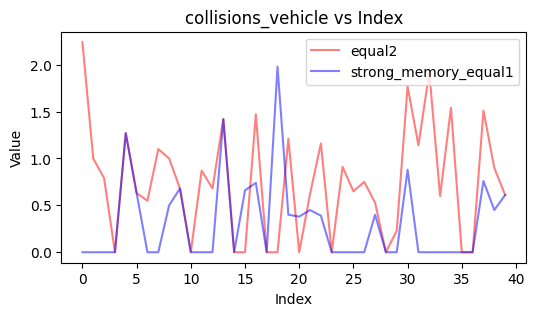

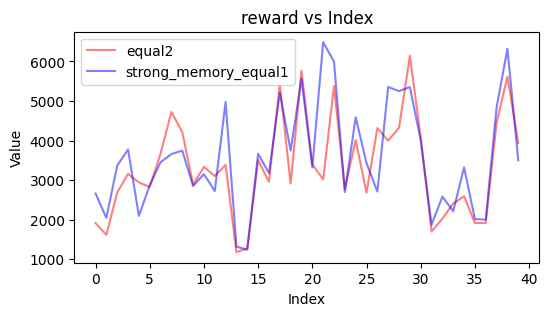

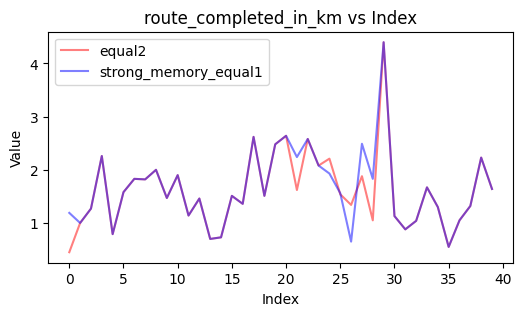

In [15]:
import pandas as pd

def plot_dfs(dfs_dict, col_name, colors, chart_type='bar', figsize=(12, 6)):
    assert len(dfs_dict) == len(colors)
    fig, ax = plt.subplots(figsize=figsize)
    for i, (label, path) in enumerate(dfs_dict.items()):
        df = read_episode_stat_buffers(path)
        df[col_name].plot(kind=chart_type, ax=ax, color=colors[i], alpha=0.5, label=label)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(f'{col_name} vs Index')
    plt.legend()
    plt.show()

# Usage example:
colors = ['red', 'blue']
plot_dfs(simulation_folder, 'collisions_vehicle', colors, chart_type='line', figsize=(6, 3))
plot_dfs(simulation_folder, 'reward', colors, chart_type='line', figsize=(6, 3))
plot_dfs(simulation_folder, 'route_completed_in_km', colors, chart_type='line', figsize=(6, 3))


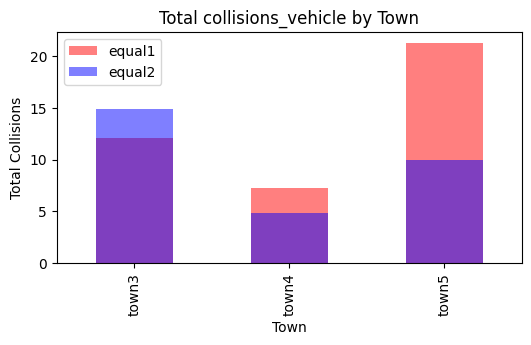

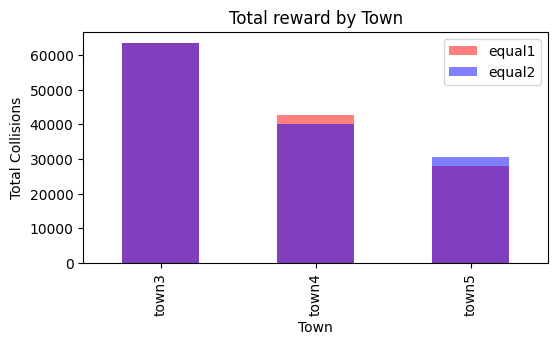

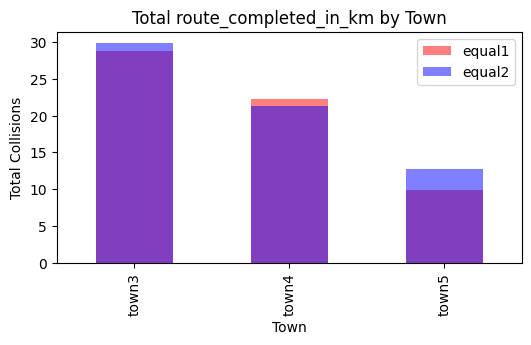

In [6]:
def plot_dfs_by_town(dfs_dict, col_name, colors, chart_type='bar', figsize=(12, 6)):
    assert len(dfs_dict) == len(colors)
    fig, ax = plt.subplots(figsize=figsize)
    for i, (label, path) in enumerate(dfs_dict.items()):
        df = read_episode_stat_buffers(path)
        # Group by town
        towns = ['town3'] * 20 + ['town4'] * 10 + ['town5'] * 10
        df['town'] = towns
        grouped_df = df.groupby('town')[col_name].sum()
        grouped_df.plot(kind=chart_type, ax=ax, color=colors[i], alpha=0.5, label=label)
    plt.xlabel('Town')
    plt.ylabel('Total Collisions')
    plt.title(f'Total {col_name} by Town')
    plt.legend()
    plt.show()

# Usage example:
colors = ['red', 'blue']
plot_dfs_by_town(simulation_folder, 'collisions_vehicle', colors, chart_type='bar', figsize=(6, 3))
plot_dfs_by_town(simulation_folder, 'reward', colors, chart_type='bar', figsize=(6, 3))
plot_dfs_by_town(simulation_folder, 'route_completed_in_km', colors, chart_type='bar', figsize=(6, 3))